In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We have decided to use Google Colab, but you are free to choose any platform for object detection.

**Tip**: When using YOLO for object detection in Colab, it is best **NOT** to mount your Google Drive. Instead, upload a ZIP folder containing your data locally. This will significantly speed up the scanning process.

In [ ]:
# Fancy way=)
import zipfile

zip_path = "/content/Dataset_200_with_tiles.zip"
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/extracted_files")
        print("Extractio made, yuppie")
except zipfile.BadZipFile:
    print("No extraction has been made")

In [ ]:
# Direct Way
!unzip "/content/Dataset_200_with_tiles.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: Dataset_200_with_tiles/labels/train/23-06-21_A5deep-36-_png.rf.91ffc4fb9bf5d5731cc811397e635e8d.txt  
  inflating: Dataset_200_with_tiles/labels/train/23-06-21_A5deep-36-_png.rf.b9608992e3f9a9f9b37a47fcb7b4b924.txt  
  inflating: Dataset_200_with_tiles/labels/train/23-06-21_A5deep-36-_png.rf.d1574fb07daa20cc9b8996a1aaeb50c3.txt  
  inflating: Dataset_200_with_tiles/labels/train/23-06-21_A5deep-37-_png.rf.2210b3b1770437150649bcc23cb09532.txt  
  inflating: Dataset_200_with_tiles/labels/train/23-06-21_A5deep-37-_png.rf.583ad9a3d7e33b5bc5fe05d7d0dd5114.txt  
  inflating: Dataset_200_with_tiles/labels/train/23-06-21_A5deep-37-_png.rf.903fccc73033dbdcbfe528656536baed.txt  
  inflating: Dataset_200_with_tiles/labels/train/23-06-21_A5deep-37-_png.rf.cfaf8ea649c05a94e0e0ef544ec487a0.txt  
  inflating: Dataset_200_with_tiles/labels/train/23-06-21_A5deep-38-_png.rf.18efe914d1ed2b28f0ed08caa04dff15.txt  
  inflating: Dataset_200_with_

In [ ]:
!pip install ultralytics==8.3.5
!pip install albumentations
!pip install pillow
!pip install supervision
import supervision as sv

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image
import glob
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab.patches import cv2_imshow
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

Ultralytics 8.3.5 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 35.5/112.6 GB disk)


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!nvidia-smi # check for the usage of the GPU because it is recommended by the author of the package

Fri Feb 21 08:37:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
image_path = "/content/drive/MyDrive/Dataset_200_null/images/train/13-04-2022-1-_png.rf.ebca69e0545d9c0511e2a3593657936c.jpg"
img = Image.open(image_path)
width, height = img.size

print(f"Dimension of the image: {width}x{height} pixel")

La dimensione dell'immagine è: 640x640 pixel


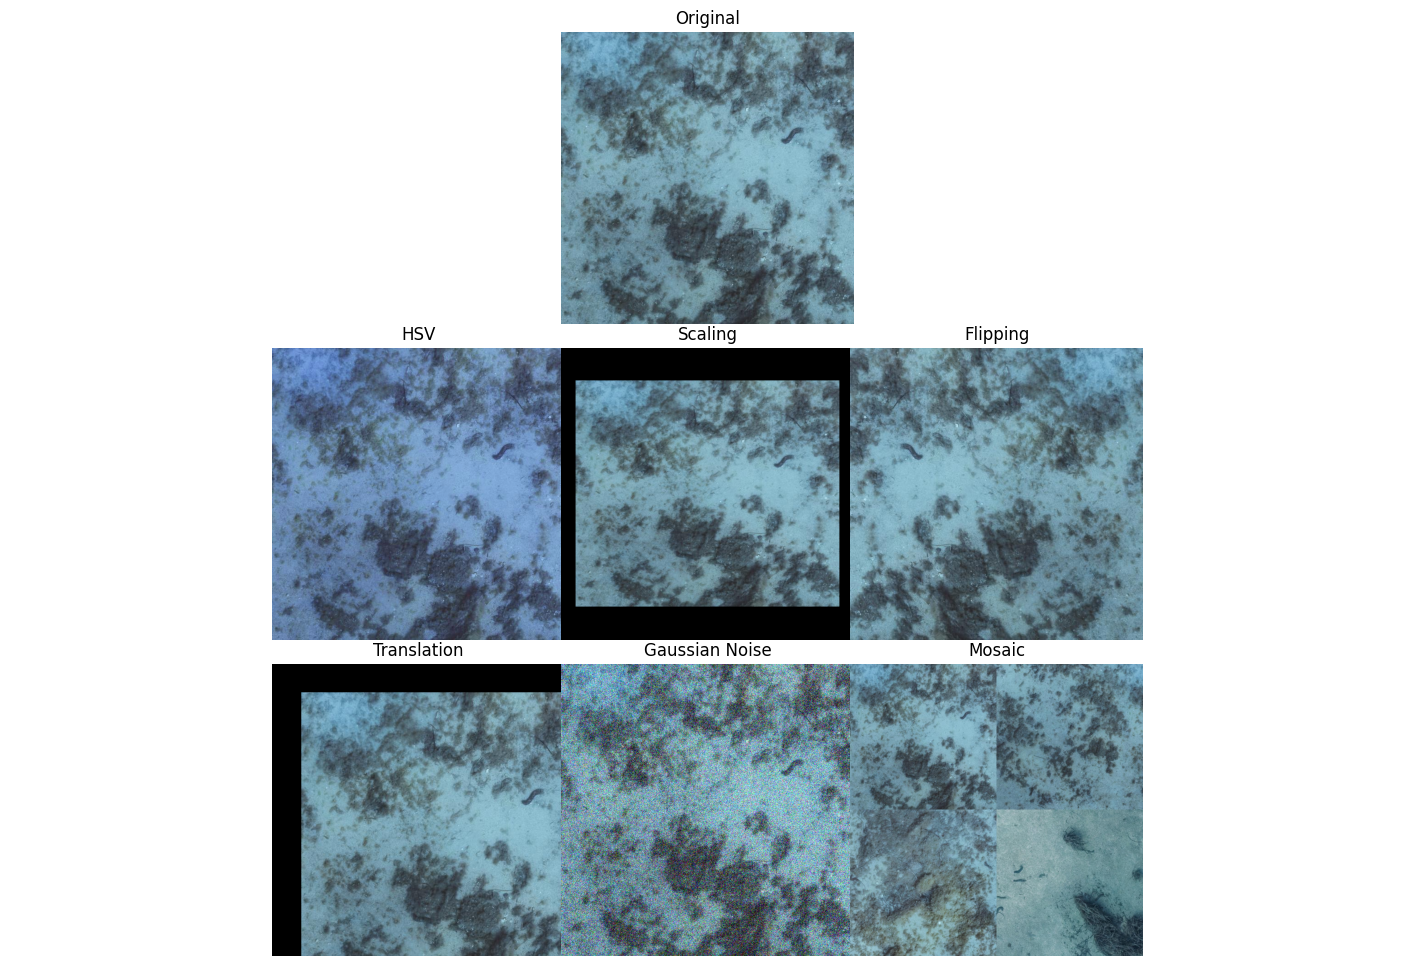

In [ ]:
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths]
def mosaic_transform(images):
    h, w, _ = images[0].shape
    mosaic = np.zeros((h * 2, w * 2, 3), dtype=np.uint8)
    mosaic[:h, :w] = images[0]
    mosaic[:h, w:] = images[1]
    mosaic[h:, :w] = images[2]
    mosaic[h:, w:] = images[3]
    return mosaic


transforms = {
    "Original": None,
    "HSV": A.Compose([A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=70, val_shift_limit=30, p=1.0)]),
    "Scaling": A.Compose([A.Affine(scale=(0.5, 1.0), p=1.0)]),
    "Flipping": A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.1)]),
    "Translation": A.Compose([A.Affine(translate_percent=(0.1, 0.1), p=1.0)]),
    "Gaussian Noise": A.Compose([A.GaussNoise(p=1.0)]),
    "Mosaic": mosaic_transform
}


augmented_images = {}
for name, t in transforms.items():
    if name == "Mosaic":
        augmented_images[name] = t(images)
    else:
        augmented_images[name] = t(image=images[0])['image'] if t else images[0]


fig, axes = plt.subplots(3, 3, figsize=(18, 12))
order = [None, "Original", None,
         "HSV", "Scaling", "Flipping",
         "Translation", "Gaussian Noise", "Mosaic"]

for ax, name in zip(axes.flat, order):
    if name is not None:
        ax.imshow(augmented_images[name])
        ax.set_title(name, fontsize=12)
    ax.axis("off")

plt.subplots_adjust(wspace=-0.646, hspace=0.08)
plt.savefig("output.png", dpi=300, bbox_inches='tight')
plt.show()





In [ ]:
plt.savefig("output.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

**The main Idea is to have the following structure**

dataset/

    images/
        train/
        val/
        test/
    labels/
        train/
        val/
        test/

In [ ]:
# First of all, it is a good practice to define the Root_Directory because at least you always know where your files will be
Root_Directory = '/content/drive/MyDrive/Dataset_200_null'

lst = os.listdir(os.path.join(Root_Directory, "labels/val"))
number_files = len(lst)
print(number_files)

368


In [ ]:

#%cd /content/drive/MyDrive/Dataset_200_null
model = YOLO('yolo11m.pt')
#model = YOLO("/content/last.pt") if you want to train fore more epochs, you can upload the last training epochs weights


In [ ]:
Root_Directory

'/content/drive/MyDrive/Dataset_200_null'

In [ ]:
results = model.train(data=os.path.join(Root_Directory, 'data.yaml'), epochs=90, imgsz=320, lr0 = 0.001,
    hsv_h=0.015,      # Hue augmentation
    hsv_s=0.7,        # Saturation augmentation
    hsv_v=0.3,        # Value (brightness) augmentation
    flipud=0.1,       # Vertical flip
    fliplr=0.5,       # Horizontal flip
    mosaic=1.0,       # mosaic augmentation
    degrees=0.0,       # Random rotation in degrees
    translate=0.1,    # Random translation
    scale=0.5,        # Scaling
    shear=0,        # Shear augmentation
    perspective=0.0,
    mixup = 0.0, single_cls = True, batch = 16, device = 0, resume = False) # if you want to resume training, use true.

In [ ]:
results = model.train(data=os.path.join(Root_Directory, 'data.yaml'), epochs=90, imgsz=320, lr0 = 0.001,
    hsv_h=0.015,      # Hue augmentation
    hsv_s=0.7,        # Saturation augmentation
    hsv_v=0.3,        # Value (brightness) augmentation
    flipud=0.1,       # Vertical flip (0% probability)
    fliplr=0.5,       # Horizontal flip (50% probability)
    mosaic=1.0,       # Use mosaic augmentation
    degrees=0.0,       # Random rotation in degrees
    translate=0.1,    # Random translation
    scale=0.5,        # Scaling
    shear=0,        # Shear augmentation
    perspective=0.0,
    mixup = 0.2, single_cls = True, batch = 16, device = 0)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install onnx # this is the way to install onnx

In [ ]:
import onnx
from onnx import version_converter

In [ ]:
model.export(format="onnx") # firstly export the weights in the onnx format

Ultralytics 8.3.5 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (38.6 MB)
requirements: Ultralytics requirements ['onnxslim==0.1.34', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 271.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 218.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 206.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 16.7s, installed 2 packages: ['onnxslim==0.1.34', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onn

'runs/detect/train/weights/best.onnx'

In [ ]:
model = onnx.load("/content/drive/MyDrive/Dataset_200_null/runs/detect/train/weights/best.onnx")
model.ir_version = 9 # there is a problem with the ir_version so you have to change it in order to use it later on in Deepness

# Save the updated model
onnx.save(model, "/content/drive/MyDrive/Dataset_200_null/runs/detect/train/weights/model_best_converted.onnx")

In [ ]:
model_best = YOLO("/content/drive/MyDrive/Dataset_200_null/runs/detect/train/weights/best.pt")

In [ ]:
metrics = model_best.val() # validation of the model

Ultralytics 8.3.5 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 26.1MB/s]
val: Scanning /content/drive/MyDrive/Dataset_200_null/labels/val.cache... 368 images, 90 backgrounds, 0 corrupt: 100%|██████████| 368/368 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/Dataset_200_null/images/val/23-06-21_A5deep-112-_png.rf.4e4544c918f121f266e86a2c08c63206.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:14<00:00,  1.61it/s]


                   all        368        628      0.851      0.863      0.917       0.75
Speed: 1.3ms preprocess, 23.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val


In [ ]:
print(metrics.box.map)
print(metrics.box.map50)
print(metrics.box.map75)
print(metrics.box.maps)

0.7498733620478601
0.9167596132841368
0.8740151801099858
[    0.74987]


In [ ]:
metrics.mean_results()

[0.85082348772957, 0.8627861419855198, 0.9167596132841368, 0.7498733620478601]

In [ ]:
pred = model_best.predict(source=os.path.join(Root_Directory, "images/test/"), save=False, conf = 0.47,
                          project=os.path.join(Root_Directory, "runs/detect/"), save_txt=False) # after having chosen a threshold, use it in the prediction setup


image 1/244 /content/drive/MyDrive/Dataset_200_null/images/test/13-04-2022-10-_png.rf.9d59f718e82bc7408204fcefb7db91a0.jpg: 640x640 2 ['Sea-cucumber']s, 37.0ms
image 2/244 /content/drive/MyDrive/Dataset_200_null/images/test/13-04-2022-133-_png.rf.12c8a8dbea6dc957606f97a932621a3a.jpg: 640x640 1 ['Sea-cucumber'], 36.9ms
image 3/244 /content/drive/MyDrive/Dataset_200_null/images/test/13-04-2022-139-_png.rf.b818fd6e3f87053da596246035e33d38.jpg: 640x640 2 ['Sea-cucumber']s, 57.6ms
image 4/244 /content/drive/MyDrive/Dataset_200_null/images/test/13-04-2022-159-_png.rf.c4a36a7ac4d056c58b83f9824a913e35.jpg: 640x640 1 ['Sea-cucumber'], 37.9ms
image 5/244 /content/drive/MyDrive/Dataset_200_null/images/test/13-04-2022-164-_png.rf.1f167b24a9e335c0bd68cad2ef41d178.jpg: 640x640 4 ['Sea-cucumber']s, 37.0ms
image 6/244 /content/drive/MyDrive/Dataset_200_null/images/test/13-04-2022-169-_png.rf.9003de443c8145043964c8d96bac610d.jpg: 640x640 3 ['Sea-cucumber']s, 36.9ms
image 7/244 /content/drive/MyDrive/D

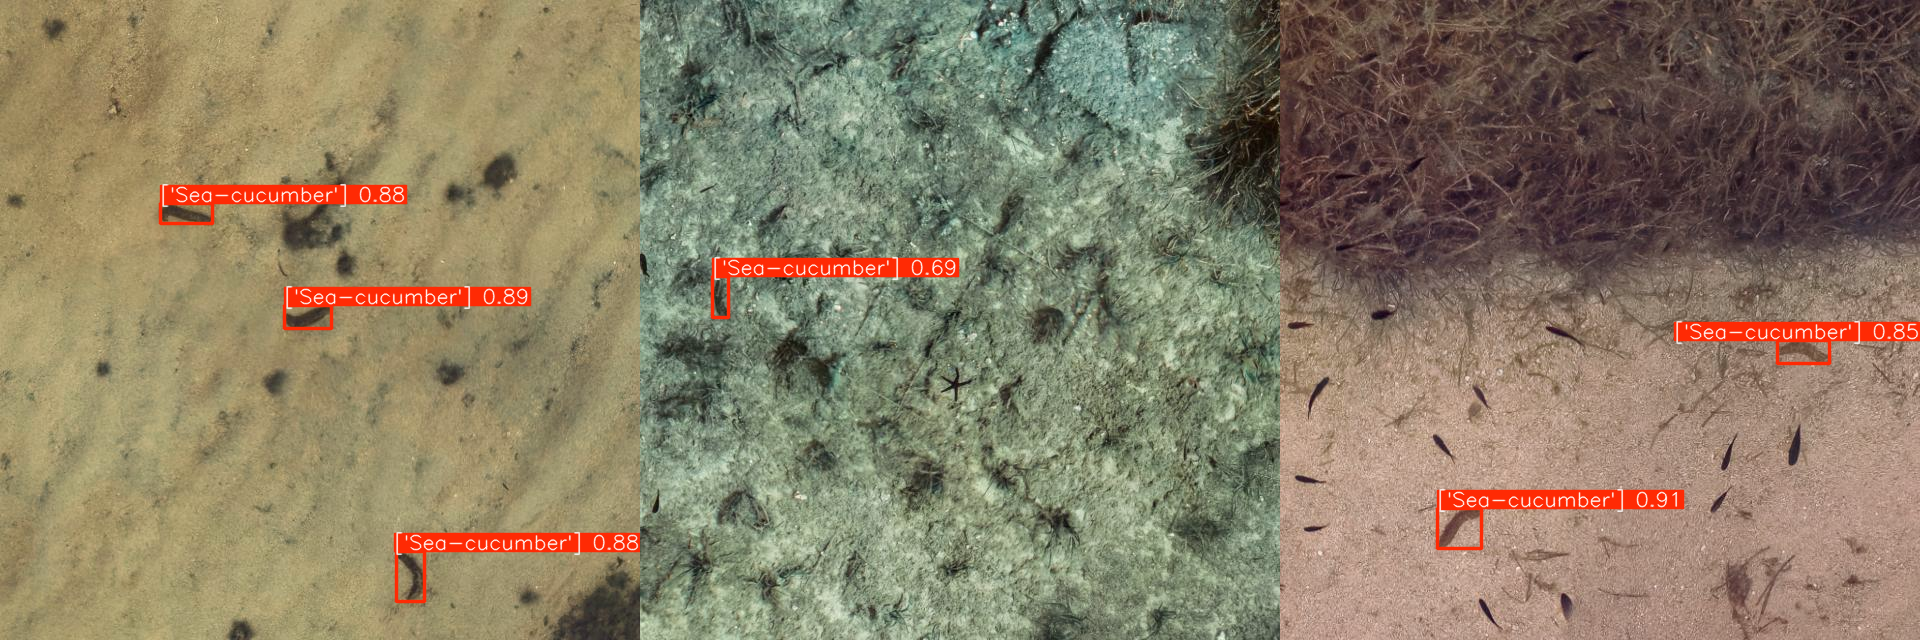

In [ ]:
# Let's visualize the predictions on just three examples
from google.colab.patches import cv2_imshow
import cv2
vec = (5, 85, 221)
images = []
for i in vec:
    img = pred[i].plot()
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img_rgb)


concatenated_img = cv2.hconcat(images)


cv2_imshow(concatenated_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


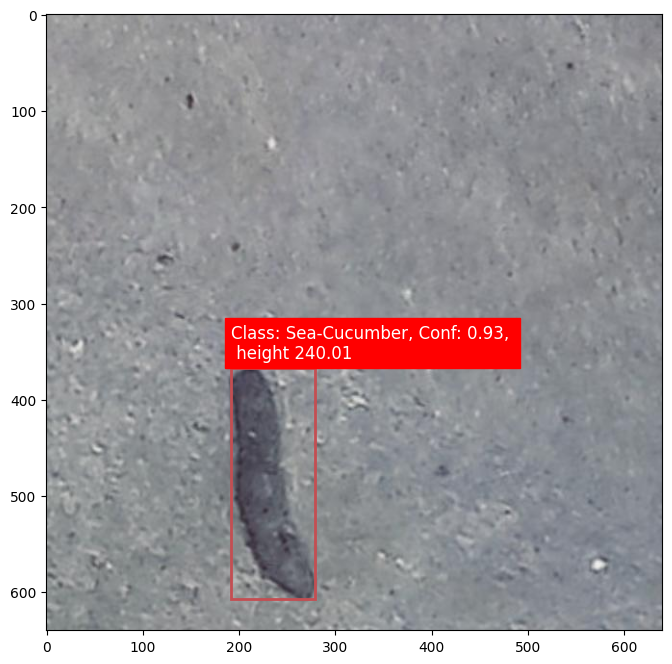

In [ ]:

# In this way you can visualize all the predictions
if pred and len(pred) > 0:

    image_path = pred[0].path
    image = PILImage.open(image_path)


    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)


    result = pred[0]
    boxes = result.boxes.xyxy.cpu().numpy()
    confidences = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()


    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min


        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


        label = f'Class: Sea-Cucumber, Conf: {confidences[i]:.2f}, \n height {height :.2f}'
        plt.text(x_min, y_min - 10, label, color='white', fontsize=12, backgroundcolor='red')


    plt.show()


In [ ]:
Root_Directory

'/content/drive/MyDrive/Dataset_200_null'

In [ ]:
Root_Directory
annot = os.path.join(Root_Directory, "labels/test/")
yam = os.path.join(Root_Directory, "data.yaml")
imag = os.path.join(Root_Directory, "images/test/")

In [ ]:
dataset = sv.DetectionDataset.from_yolo(annotations_directory_path=annot, data_yaml_path=yam, images_directory_path=imag)

In [ ]:
dataset.annotations

In [ ]:
def callback(image: np.ndarray) -> sv.Detections:
    result = model_best(image, conf = 0.47)[0]
    return sv.Detections.from_ultralytics(result)

confusion_matrix = sv.ConfusionMatrix.benchmark(
   dataset = dataset,
   callback = callback
)

# Using Supervision package is pretty good because you can easily see the confusion matrix in the prediction step, while YOLO does not provide it

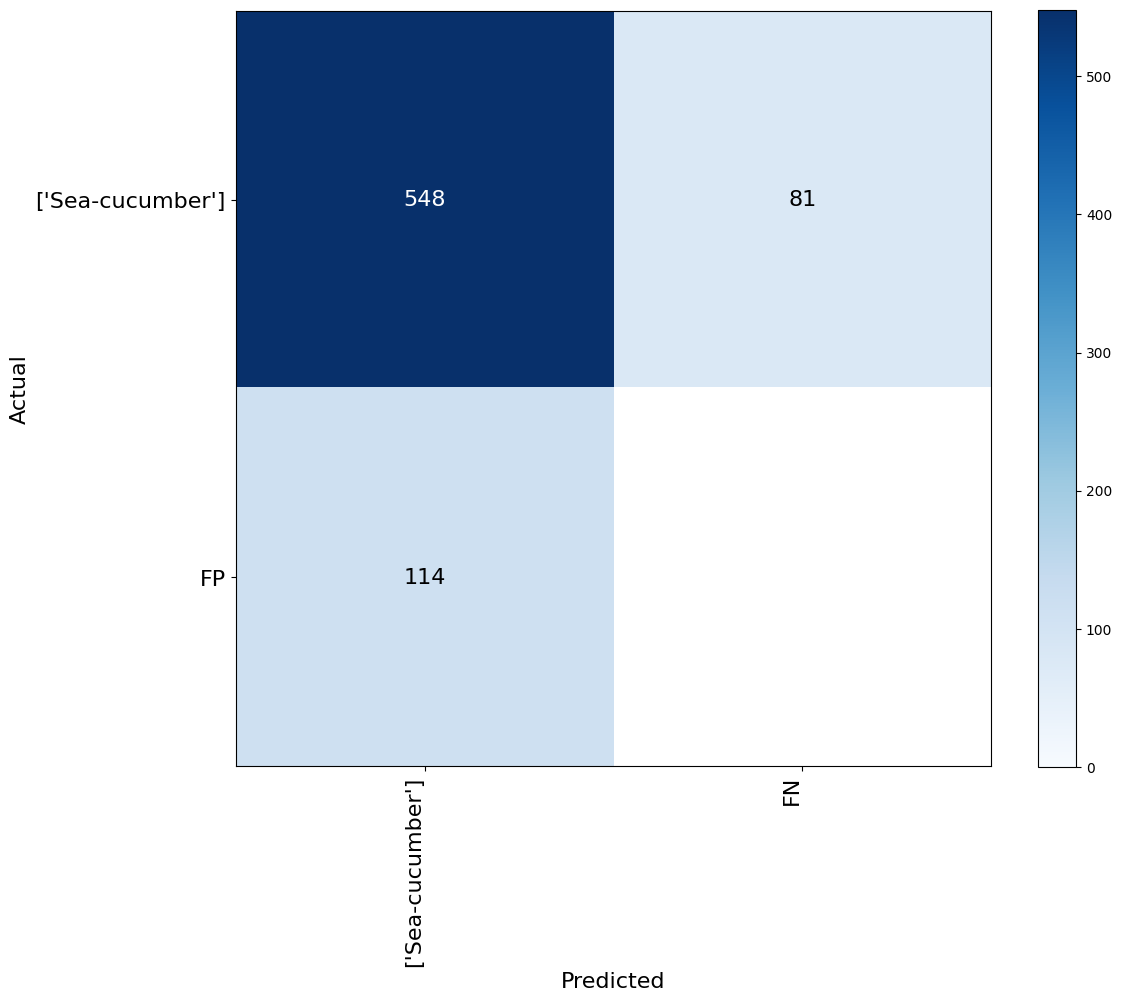

In [ ]:
sns.reset_orig()
confusion_matrix.plot()
fig = plt.gcf()
ax = plt.gca()
ax.set_xlabel("Predicted", fontsize=16)
ax.set_ylabel("Actual", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
for text in ax.texts:
    text.set_fontsize(16)

plt.show()


In [ ]:
pr_scores = metrics.curves_results[0] # precision-recall scores

In [ ]:
f1_scores = metrics.box.f1_curve # f1-scores

In [ ]:
p = metrics.box.p_curve[0] # precision-scores
r = metrics.box.r_curve[0] # recall-scores


def f1_score(p, r, b): # F_beta Score
    return (1 + b**2) * (p * r) / (b**2 * p + r)

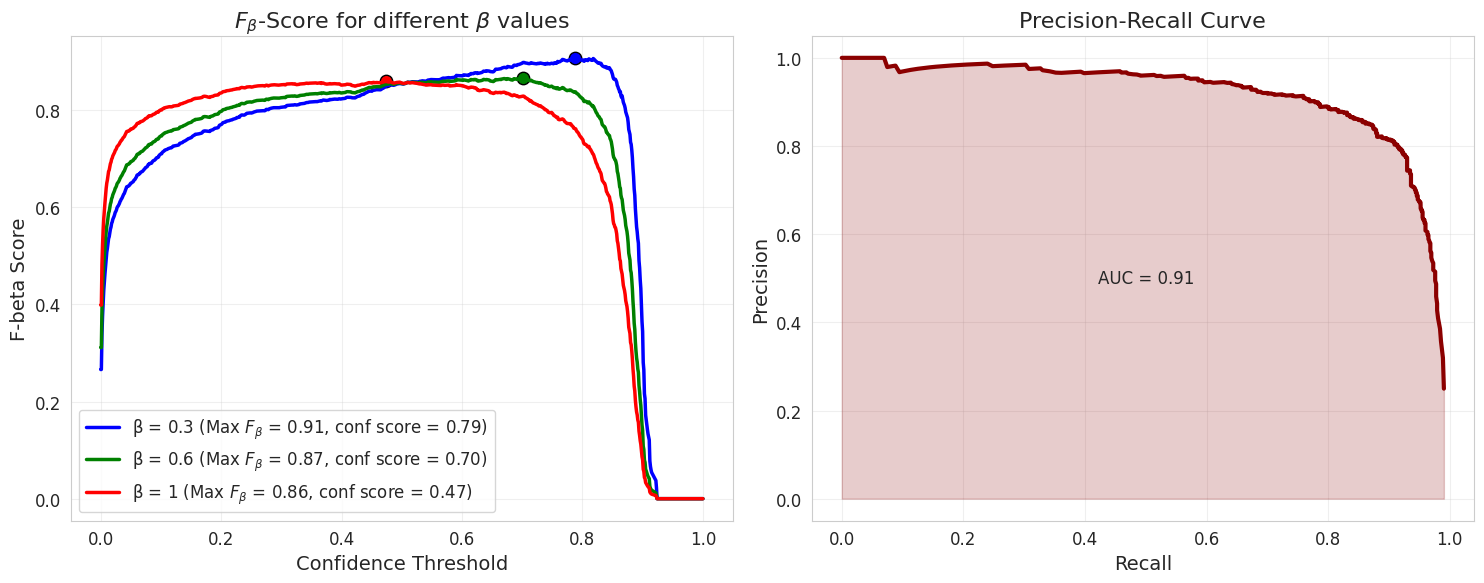

In [ ]:

sns.set_style("whitegrid")


beta_values = [0.3, 0.6, 1]
conf_thresholds = np.linspace(0, 1, len(p))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

colors = ['blue', 'green', 'red']
for beta, color in zip(beta_values, colors):
    f1_values = f1_score(p, r, beta)
    max_f1_index = np.argmax(f1_values)
    max_f1_score = f1_values[max_f1_index]
    optimal_threshold = conf_thresholds[max_f1_index]


    ax1.plot(conf_thresholds, f1_values, color=color, lw=2.5,
             label=rf'β = {beta} (Max $F_{{\beta}}$ = {max_f1_score:.2f}, conf score = {optimal_threshold:.2f})')


    ax1.scatter(optimal_threshold, max_f1_score, color=color,
               edgecolor='black', s=80)

ax1.set_xlabel('Confidence Threshold', fontsize=14)
ax1.set_ylabel('F-beta Score', fontsize=14)
ax1.set_title(r"$F_{\beta}$-Score for different $\beta$ values", fontsize=16)
ax1.legend(loc='lower left', fontsize=12, frameon=True)
ax1.grid(alpha=0.3)


pr_auc = auc(r, p)
ax2.plot(r, p, color='darkred', lw=3)
ax2.fill_between(r, p, alpha=0.2, color='darkred')
ax2.text(0.5, 0.5, f'AUC = {pr_auc:.2f}', fontsize=12,
         horizontalalignment='center', verticalalignment='center')
ax2.set_xlabel('Recall', fontsize=14)
ax2.set_ylabel('Precision', fontsize=14)
ax2.set_title('Precision-Recall Curve', fontsize=16)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()
